# Point in Polygon & Intersect

[Vuokko Heikinheimo, Henrikki Tenkanen](https://automating-gis-processes.github.io/)  
Department of Geosciences & Geography, University of Helsinki  

Finding out if a certain point is located inside or outside of an area,
or finding out if a line intersects with another line or polygon are
fundamental geospatial operations that are often used e.g. to select
data based on location. Such spatial queries are one of the typical
first steps of the workflow when doing spatial analysis. Performing a
spatial join (will be introduced later) between two spatial datasets is
one of the most typical applications where Point in Polygon (PIP) query
is used. 

For further reading about PIP and other geometric operations, 
see Chapter 4.2 in Smith, Goodchild & Longley: [Geospatial Analysis - 6th edition](https://www.spatialanalysisonline.com/HTML/index.html).

## How to check if point is inside a polygon?

Computationally, detecting if a point is inside a polygon is most commonly done using a specific formula called [Ray Casting algorithm](https://en.wikipedia.org/wiki/Point_in_polygon#Ray_casting_algorithm).
Luckily, we do not need to create such a function ourselves for
conducting the Point in Polygon (PIP) query. Instead, we can take
advantage of [Shapely's binary predicates](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates)
that can evaluate the topolocical relationships between geographical
objects, such as the PIP as we're interested here.

There are basically two ways of conducting PIP in Shapely:

1. using a function called
   [within()](https://shapely.readthedocs.io/en/stable/manual.html#object.within)
   that checks if a point is within a polygon
2. using a function called
   [contains()](https://shapely.readthedocs.io/en/stable/manual.html#object.contains)
   that checks if a polygon contains a point

Notice: even though we are talking here about **Point** in Polygon
operation, it is also possible to check if a LineString or Polygon is
inside another Polygon.

Let's import shapely functionalities and create some points:

In [49]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
from shapely import speedups


In [18]:
# Create Point objects
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

Let's also create a polygon using a list of coordinate-tuples:

In [19]:
# Create a Polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)

In [20]:
# Let's check what we have
print(p1)
print(p2)
print(poly)

POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


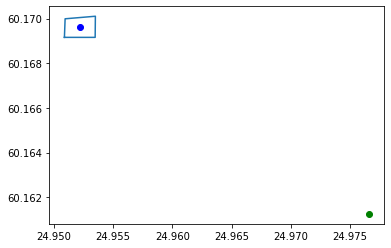

In [21]:
# Does polygon contain p2?
poly.contains(p2)

x, y = poly.exterior.coords.xy
x1, y1 = p1.coords[:][0]
x2, y2 = p2.coords[:][0]

plt.plot(x, y)
plt.plot(x1, y1, "bo")
plt.plot(x2, y2, "go")

- Let's check if those points are ``within`` the polygon:

In [22]:
# Check if p1 is within the polygon using the within function
p1.within(poly)

True

In [23]:
# Check if p2 is within the polygon
p2.within(poly)

False

Okey, so we can see that the first point seems to be inside that polygon
and the other one isn't.

-In fact, the first point is quite close to close to the center of the polygon as we
can see if we compare the point location to the polygon centroid:

In [24]:
# Our point
print(p1)

# The centroid
print(poly.centroid)

POINT (24.952242 60.1696017)
POINT (24.95224242849236 60.16960179038188)


It is also possible to do PIP other way around, i.e. to check if
polygon contains a point:

In [25]:
# Does polygon contain p1?
poly.contains(p1)

True

Thus, both ways of checking the spatial relationship are identical; [contains()](https://shapely.readthedocs.io/en/stable/manual.html#object.contains) is inverse to [within()](https://shapely.readthedocs.io/en/stable/manual.html#object.within) and vice versa.

Which one should you use then? Well, it depends:

-  if you have **many points and just one polygon** and you try to find out
   which one of them is inside the polygon: You might need to iterate over the points and check one at a time if it
   is **within()** the polygon.

-  if you have **many polygons and just one point** and you want to find out
   which polygon contains the point: You might need to iterate over the polygons until you find a polygon that **contains()** the point specified (assuming there are no overlapping polygons)
        
## Intersect


Another typical geospatial operation is to see if a geometry intersects
or touches another one. Again, there are binary operations in Shapely for checking these spatial relationships:

- [intersects():](https://shapely.readthedocs.io/en/stable/manual.html#object.intersects) Two objects intersect if the boundary or interior of one object intersect in any way with the boundary or interior of the other object.

- [touches():](https://shapely.readthedocs.io/en/stable/manual.html#object.touches) Two objects touch if the objects have at least one point in common and their interiors do not intersect with any part of the other object.
   

Let's try these out.

Let's create two LineStrings:

In [26]:
# Create two lines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])

Let's see if they intersect

In [27]:
line_a.intersects(line_b)

True

Do they also touch?

In [28]:
line_a.touches(line_b)

True

Indeed, they do and we can see this by plotting the features together

In [ ]:
# Plot lines
x_a, y_a = line_a.xy
x_b, y_b = line_b.xy
plt.plot(x_a, y_a)
plt.plot(x_b, y_b)

Thus, the ``line_b`` continues from the same node ( (1,1) ) where ``line_a`` ends.

However, if the lines overlap fully, they don't touch due to the spatial relationship rule, as we can see:

Check if `line_a` touches itself:

In [30]:
# Does the line touch with itself?
line_a.touches(line_a)

False

It does not. However, it does intersect:

In [31]:
# Does the line intersect with itself?
line_a.intersects(line_b)

True

## Point in Polygon using Geopandas

Next we will do a practical example where we check which of the addresses from [the geocoding tutorial](geocoding_in_geopandas.ipynb) are located in Southern district of Helsinki. Let's start by reading a KML-file ``PKS_suuralue.kml`` that has the Polygons for districts of Helsinki Region (data openly available from [Helsinki Region Infoshare](http://www.hri.fi/fi/dataset/paakaupunkiseudun-aluejakokartat).

Let's start by reading the addresses from the Shapefile that we saved earlier.

In [37]:
# Define your path
fp = ["..", "data", "Addresses", "addresses.shp"]
data_file = os.path.join(*fp)
data = gpd.read_file(data_file)

data.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Hermanninmäki, Hermanni, K...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97759 60.19361)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)



### Reading KML-files in Geopandas

It is possible to read the data from KML-files with GeoPandas in a similar manner as Shapefiles. However, we need to first, enable the KML-driver which is not enabled by default (because KML-files can contain unsupported data structures, nested folders etc., hence be careful when reading KML-files). Supported drivers are managed with [`fiona.supported_drivers`](https://github.com/Toblerity/Fiona/blob/master/fiona/drvsupport.py), which is integrated in geopandas. Let's first check which formats are currently supported:

In [38]:
gpd.io.file.fiona.drvsupport.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'rw',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

- Let's enable the read and write functionalities for KML-driver by passing ``'rw'`` to whitelist of fiona's supported drivers:

In [39]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

Let's check again the supported drivers:

In [40]:
gpd.io.file.fiona.drvsupport.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'rw',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r',
 'KML': 'rw'}

Now we should be able to read a KML file using the geopandas [read_file()](http://geopandas.org/reference/geopandas.read_file.html#geopandas.read_file) function.

- Let's read district polygons from a KML -file that is located in the data-folder:

In [42]:
# Filepath to KML file
fp = ["..", "data", "PKS_suuralue.kml"]
file = os.path.join(*fp)
polys = gpd.read_file(file, driver = "KML")

polys.head()

/home/magdalena/zazuko/gis-training-solutions/venv/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."


In [43]:
#Check the data
polys.head(6)
len(polys)

23

Nice, now we can see that we have 23 districts in our area. 
Let's quickly plot the geometries to see how the layer looks like: 

<AxesSubplot:>

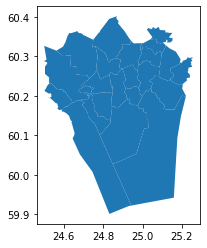

In [72]:
polys.plot()

We are interested in an area that is called ``Eteläinen`` (*'Southern'* in English).

Let's select the ``Eteläinen`` district and see where it is located on a map:


In [44]:
# Select data 
southern = polys[polys["Name"] == "Eteläinen"]

In [45]:
# Reset index for the selection
southern.reset_index(drop=True, inplace=True)

In [46]:
# Check the selction
southern

,Name,Description,geometry
0,Eteläinen,,"POLYGON Z ((24.78277 60.09997 0.00000, 24.8197..."


- Let's create a map which shows the location of the selected district, and let's also plot the geocoded address points on top of the map:

<AxesSubplot:>

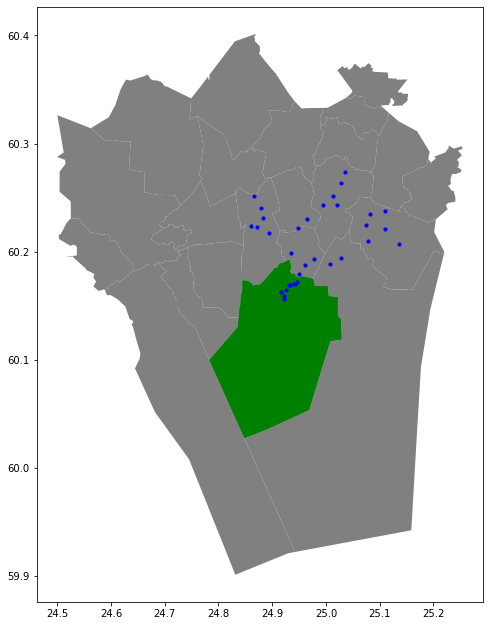

In [47]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8,12))

# Plot polygons
polys.plot(ax=ax, facecolor="gray")
southern.plot(ax=ax, facecolor="green")

# Plot points
data.plot(ax=ax, color="blue", markersize=10)


Okey, so we can see that, indeed, certain points are within the selected red Polygon.

Let's find out which one of them are located within the Polygon. Hence, we are conducting a **Point in Polygon query**.

First, let's check that we have  `shapely.speedups` enabled. This module makes some of the spatial queries running faster (starting from Shapely version 1.6.0 Shapely speedups are enabled by default):

In [50]:
speedups.enabled

# If false, run this line:
#shapely.speedups.enable()

True

- Let's check which Points are within the ``southern`` Polygon. Notice, that here we check if the Points are ``within`` the **geometry**
  of the ``southern`` GeoDataFrame. 
- We use the ``.at[0, 'geometry']`` to parse the actual Polygon geometry object from the GeoDataFrame.

In [51]:
pip_mask = data.within(southern.at[0, "geometry"])
pip_mask

0      True
1      True
2      True
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33     True
dtype: bool

As we can see, we now have an array of boolean values for each row, where the result is ``True``
if Point was inside the Polygon, and ``False`` if it was not.

We can now use this mask array to select the Points that are inside the Polygon. Selecting data with this kind of mask array (of boolean values) is easy by passing the array inside the ``loc`` indexer:


In [52]:
pip_data = data[pip_mask]
pip_data

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)
10,"Rautatientori, 2, Kaivokatu, Keskusta, Kluuvi,...",1011,"Rautatientori 1, 00100 Helsinki, Finland",POINT (24.93985 60.17038)
30,"Kampin keskus, 1, Urho Kekkosen katu, Kamppi, ...",1031,"Urho Kekkosen katu 1, 00100 Helsinki, Finland",POINT (24.93312 60.16909)
31,"Ruoholahdenkatu, Hietalahti, Kamppi, Eteläinen...",1032,"Ruoholahdenkatu 17, 00101 Helsinki, Finland",POINT (24.92496 60.16497)
32,"Easy Cycles, 3, Tyynenmerenkatu, Jätkäsaari, L...",1033,"Tyynenmerenkatu 3, 00220 Helsinki, Finland",POINT (24.92119 60.15890)
33,"Oluthuone Kaisla, 4, Vilhonkatu, Kaisaniemi, K...",1034,"Vilhonkatu 4, 00101 Helsinki, Finland",POINT (24.94709 60.17191)


Let's finally confirm that our Point in Polygon query worked as it should by plotting the points that are within the southern district:

<AxesSubplot:>

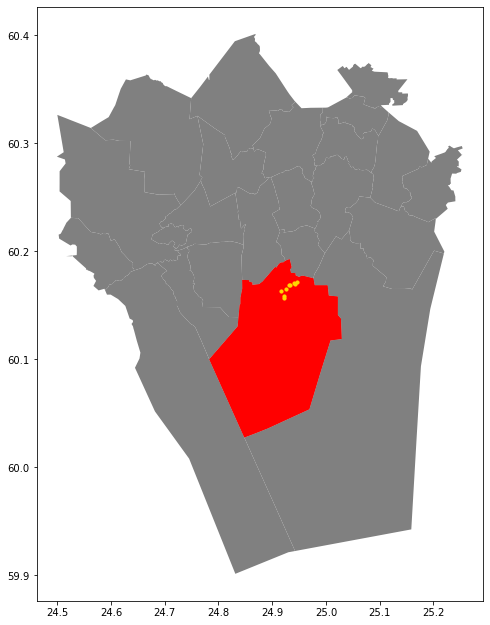

In [53]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(8,12))

# Plot polygons
polys.plot(ax=ax, facecolor="gray")
southern.plot(ax=ax, facecolor="red")


# Plot points
pip_data.plot(ax=ax, color="gold", markersize=10)



Perfect! Now we only have the (golden) points that, indeed, are inside the red Polygon which is exactly what we wanted!